In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
rng = np.random.default_rng(seed=1)

#### Generate simulated data D, distributed exponentially with true decay constant lambda_true = 5 cm

In [3]:
D = np.empty(1000)
j = 0
# I removed the division of the data by z; if you do divide by z, the mean of the data does not match
# the rate parameter anymore, so I am not sure it is actually correct.
# z = np.exp(-1 / 5) - np.exp(-20 / 5)
while j < len(D):
    rand_x = rng.exponential(5)
    if rand_x <= 20 and rand_x >= 1:
        D[j] = rand_x
        j += 1 

print(np.mean(D))

5.51706353469632


In [4]:
def get_P_l(lambda_cur, lambda_mean, sigma):
    return np.exp(-(lambda_cur-lambda_mean)**2/(2*sigma**2))/(2*np.pi*sigma**2)**(0.5)

def get_P_xl(lambda_cur, N, data):
    z_l = np.exp(-1 / lambda_cur) - np.exp(-20 / lambda_cur)
    return np.exp(-np.sum(data[:N]) / lambda_cur) / ((lambda_cur * z_l) ** N)

def get_P_xl_alt(lambda_cur, N, data):
    z_l = np.exp(-1 / lambda_cur) - np.exp(-20 / lambda_cur)
    return np.exp(N*np.log(1/(lambda_cur*z_l)) - np.sum(data[:N])/lambda_cur)

In [13]:
lam = np.arange(1,20,0.1)
l_prior = 8
sigma_prior = 4
N_range = range(1, 280)

prior = np.array([get_P_l(l, l_prior, sigma_prior) for l in lam])
posteriors = np.empty([len(N_range), len(lam)]) 

for N in N_range:
    P_xl = np.empty(len(lam))
    P_lx = np.empty(len(lam))
    i = 0
    for l in lam:
        P_xl[i] = get_P_xl_alt(l, N, D)
        P_lx[i] = P_xl[i] * prior[i]
        i +=1
    P_lx = P_lx / np.trapz(P_lx, lam)
    
    posteriors[N-1] = P_lx

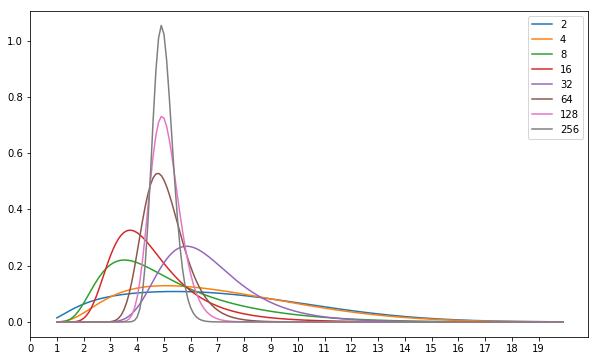

In [15]:
plt.figure(figsize = (10,6))
selected_N = [
    2,
    4,
    8,
    16,
    32,
    64,
    128,
    256,
#     612,
#     1024
]
for N in selected_N:
    plt.plot(lam, posteriors[N-1], label = N)
plt.legend()
p = plt.xticks(range(0,20,1))
#plt.ylim(0,3)

#### Plot the mode of posterior and its width as a function of N

In [16]:
modes = []
stds = []
for distr in posteriors:
    mode = lam[distr.argmax()]
    integrand = [((l - mode)**2) *  distr[key] for key, l in enumerate(lam)]
    std = (np.trapz(integrand, lam))**(0.5)
    modes.append(mode)
    stds.append(std)

Text(0.5, 0, 'N')

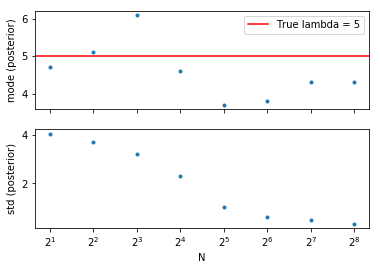

In [29]:
fig, ax = plt.subplots(2, 1, figsize = (6,4), sharex = True)

ax[0].plot(selected_N, [modes[N-1] for N in selected_N], '.')
ax[0].axhline(y=5, color='r', linestyle='-', label = 'True lambda = 5')
ax[0].set_xscale('log', basex=2)
#ax[0].set_yticks(range(4,12,2))
# ax[0].set_title('Mode of the posterior as a function of N')
ax[0].set_ylabel("mode (posterior)")
ax[0].legend()

ax[1].plot(selected_N, [stds[N-1] for N in selected_N], '.')
ax[1].set_xscale('log', basex=2)
ax[1].set_ylabel("std (posterior)")

ax[1].set_xlabel("N")


#ax[1].set_yticks(range(4,12,1))

#### How many datapoints are needed to clain that the true value of lambda is less than 8cm with 95% certainty?

In [18]:
n_thr = 0
for distr in posteriors:
    x = lam[lam <=8]
    distr = distr[:len(x)]
    n_thr += 1
    if np.trapz(distr, x) >= 0.95:
        break
print(n_thr)

12


## Many simulations!

In [19]:
lambda_true = 5
total_N = 280
z = np.exp(-1 / 5) - np.exp(-20 / 5)
N_sim = 10
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

lam = np.arange(1, 20, 0.1)
l_prior = 8
sigma_prior = 4
N_range = range(1, total_N)

all_post = np.empty([N_sim, total_N - 1, len(lam)]) 

for simN in range(N_sim):
    data = np.empty(total_N)
    rng = np.random.default_rng(seed=seeds[simN])
    # you forgot to set j = 0 here before, so you reused the same data for the last 9 reps
    j = 0
    while j < total_N:
        rand_x = rng.exponential(lambda_true)
        # I don't think you need to divide here. If you do, the mean of the data doesn't match
        # the rate parameter anymore.
        # rand_x = np.random.exponential(lambda_true) / z
        if rand_x <= 20 and rand_x >= 1:
            data[j] = rand_x
            j += 1 
    
    prior = np.array([get_P_l(l, l_prior, sigma_prior) for l in lam])
    posteriors = np.empty([len(N_range), len(lam)]) 
    for N in N_range:
        P_xl = np.empty(len(lam))
        P_lx = np.empty(len(lam))
        i = 0
        for l in lam:
            P_xl[i] = get_P_xl_alt(l, N, data)
            P_lx[i] = P_xl[i] * prior[i]
            i +=1
        P_lx = P_lx / np.trapz(P_lx, lam)

        posteriors[N-1] = P_lx
        # I believe that you actually don't want to update your prior here;
        # you have to do it if you iterate through your data one by one, but you skip
        # that with that multiplication formula of yours.
        # If you update it, your N = 2 has actually used 3 data points
        # for the posterior, N = 3 has used 6 and so on; 
        # I think, by that underestimate the number of datapoints you need for the 
        # rejection of lambda = 8
        # prior = P_lx
        
    all_post[simN] = posteriors

In [20]:
all_modes = []
all_stds = []
for sim in all_post:
    modes = []
    stds = []
    for distr in sim:
        mode = lam[distr.argmax()]
        integrand = [((l - mode)**2) *  distr[key] for key, l in enumerate(lam)]
        std = (np.trapz(integrand, lam))**(0.5)
        modes.append(mode)
        stds.append(std)
    all_modes.append(modes)
    all_stds.append(stds)

#print(all_modes)
#print(all_stds)

(0, 0.9876075633309553)

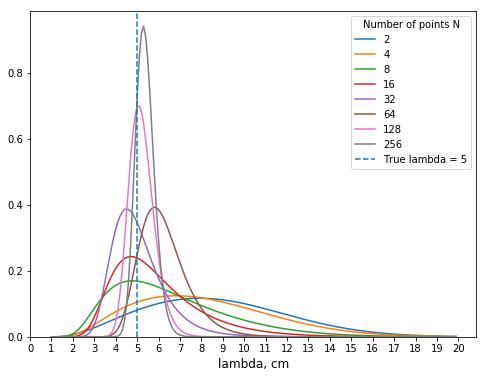

In [52]:
plt.figure(figsize = (8,6))
selected_N = [
    2,4,8,16,32,64,128,256
]
for N in selected_N:
    plt.plot(lam, all_post[4][N-1], label = N)
plt.axvline(x=5, ls = '--', label ='True lambda = 5')
plt.legend(title = 'Number of points N')
plt.xlabel('lambda, cm', fontsize = 12)
p = plt.xticks(range(0,21,1))
plt.ylim(0)

In [22]:
all_modes_mean = np.mean(all_modes, axis = 0)
all_modes_std = np.std(all_modes, axis = 0)
all_stds_mean = np.mean(all_stds, axis = 0)
all_stds_std = np.std(all_stds, axis = 0)

Text(0.5, 0, 'N')

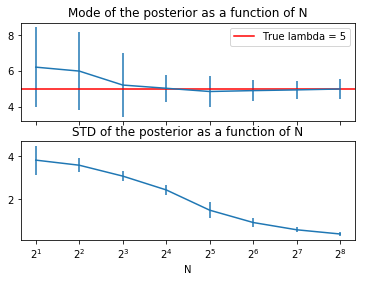

In [30]:
fig, ax = plt.subplots(2, 1, figsize = (6,4), sharex = True)

ax[0].errorbar(x = selected_N, y = [all_modes_mean[N-1] for N in selected_N], 
               yerr = [all_modes_std[N-1] for N in selected_N], linestyle = '-')
ax[0].axhline(y=5, color='r', linestyle='-', label = 'True lambda = 5')
ax[0].set_xscale('log', basex=2)
#ax[0].set_yticks(range(4,12,2))
ax[0].set_title('Mode of the posterior as a function of N')
ax[0].legend()

ax[1].errorbar(x = selected_N, y = [all_stds_mean[N-1] for N in selected_N], yerr = [all_stds_std[N-1] for N in selected_N])
ax[1].set_xscale('log', basex=2)
ax[1].set_title('STD of the posterior as a function of N')
ax[1].set_xlabel('N')

#ax[1].set_yticks(range(4,12,1))

In [24]:
#How many datapoints are needed to clain that the true value of lambda is less than 8cm with 95% certainty?
x = lam[lam <= 8]
n_thr = [0]*N_sim
i = 0
for sim in all_post:
    for distr in sim:
        distr = distr[:len(x)]
        n_thr[i] += 1
        if np.trapz(distr, x) >= 0.95:
            break
    i += 1
print(n_thr, np.mean(n_thr))

[12, 12, 23, 61, 29, 24, 29, 21, 35, 24] 27.0
